In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pulp as pl
from scipy import stats

plt.rcParams['figure.figsize'] = [15,10]
np.seterr(all='raise')
np.seterr(under="ignore")

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [2]:
TRANS_FEE_RATE = 0.03 / 100
EXER_FEE_RATE = 0.015 / 100

In [3]:
def plot_price(price):
    plt.plot([price, price], plt.ylim())

In [4]:
def value_option_buy_call(d, xs):
    y = xs - d.strikePrice
    y[y <= 0] = 0
    return y
    
def value_option_sell_call(d, xs):
    y = xs - d.strikePrice
    y[y <= 0] = 0
    y -= d.price
    return -y
    
def value_option_buy_put(d, xs):
    y = -(xs - d.strikePrice)
    y[y <= 0] = 0
    return y
        
def value_option_sell_put(d, xs):
    y = -(xs - d.strikePrice)
    y[y <= 0] = 0
    y -= d.price
    return -y

In [5]:
def cost_option_buy_call(d, xs):
    return np.ones_like(xs) * d.price #+ d.indexPrice * TRANS_FEE_RATE + value_option_buy_call(d, xs) * EXER_FEE_RATE
    
def cost_option_sell_call(d, xs):
    return np.zeros_like(xs) #+ d.indexPrice * TRANS_FEE_RATE
    
def cost_option_buy_put(d, xs):
    return np.ones_like(xs) * d.price #+ d.indexPrice * TRANS_FEE_RATE + value_option_buy_put(d, xs) * EXER_FEE_RATE
        
def cost_option_sell_put(d, xs):
    return np.zeros_like(xs) #+ d.indexPrice * TRANS_FEE_RATE

In [6]:
def pl_order(d, xs):
    if d.optionType == "C" and d.side == "ASK":
        val = value_option_buy_call(d, xs)
        cost = cost_option_buy_call(d, xs)
    elif d.optionType == "C" and d.side == "BID":
        val = value_option_sell_call(d, xs)
        cost = cost_option_sell_call(d, xs)
    elif d.optionType == "P" and d.side == "ASK":
        val = value_option_buy_put(d, xs)
        cost = cost_option_buy_put(d, xs)
    elif d.optionType == "P" and d.side == "BID":
        val = value_option_sell_put(d, xs)
        cost = cost_option_sell_put(d, xs)
    else:
        raise ValueError(d)
        
    return val-cost

In [7]:
def cost_order(d, xs):
    if d.optionType == "C" and d.side == "ASK":
        cost = cost_option_buy_call(d, xs)
    elif d.optionType == "C" and d.side == "BID":
        cost = cost_option_sell_call(d, xs)
    elif d.optionType == "P" and d.side == "ASK":
        cost = cost_option_buy_put(d, xs)
    elif d.optionType == "P" and d.side == "BID":
        cost = cost_option_sell_put(d, xs)
    else:
        raise ValueError(d)
        
    return cost

In [221]:
df = pd.read_csv("orderbook_snapshot_210430.csv")

In [222]:
indexPrice = np.mean(df.indexPrice)

xs = np.linspace(int(indexPrice*0.1), int(indexPrice*1.8), 10_000)
objective_weights = stats.norm.pdf(xs, indexPrice, 5_000)

def obj_specifier(vals):
    return np.sum(vals * objective_weights)

BUDGET = 20
MAX_LOSS_PRTG = -0.1 # ratio
MAX_LOSS_PRCTG_FX = lambda x: np.fmin(- 4 * np.abs(x - indexPrice) / indexPrice, MAX_LOSS_PRTG)
MAX_LOSS_PRCTG_FX = lambda x: MAX_LOSS_PRTG * np.ones_like(x)

print(f"{indexPrice}")
loss_boundry = (indexPrice*0.50, indexPrice*1.50)

58927.74159999981


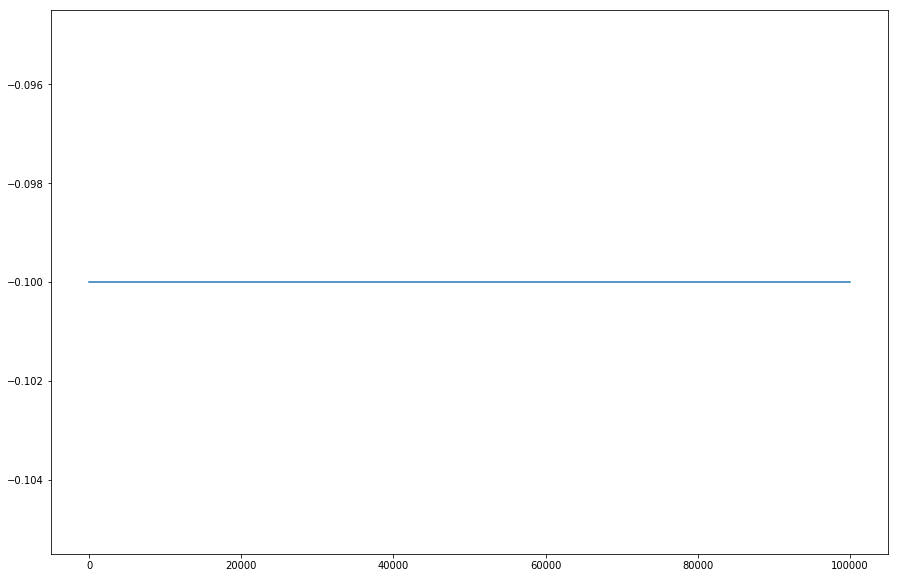

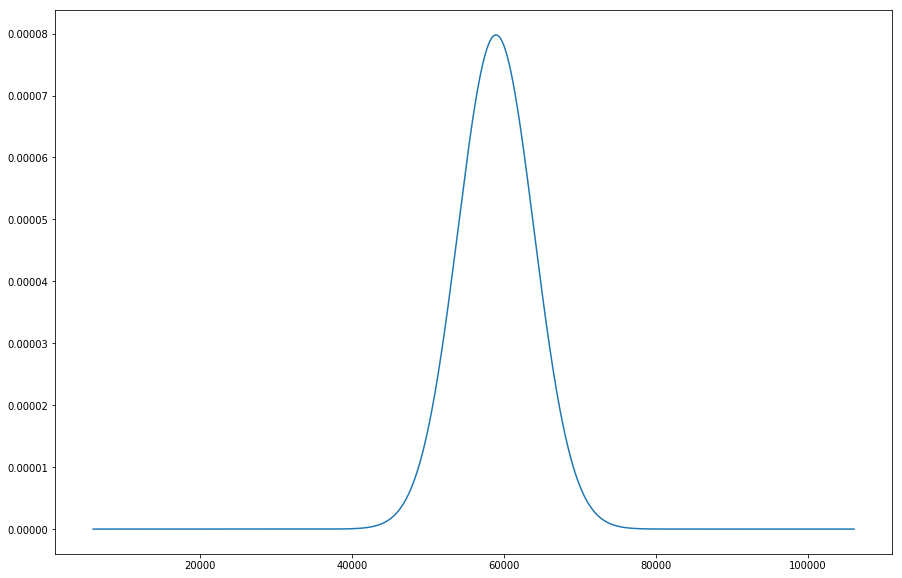

In [223]:
xs_max_loss = np.linspace(0, 1e5, 1000)
plt.plot(xs_max_loss, MAX_LOSS_PRCTG_FX(xs_max_loss))
plt.show()
plt.plot(xs, objective_weights)

In [224]:
solver = pl.GLPK_CMD(path="/usr/local/Cellar/glpk/5.0/bin/glpsol")

loss_xs = np.linspace(int(loss_boundry[0]), int(loss_boundry[1]), 200)

model = pl.LpProblem("OptionTradingStrategy", pl.LpMaximize)

options = list(df.index)
option_cost_variable = pl.LpVariable.dicts(
    'option_invest',
    options, 
    lowBound = 0.0
)


print("max quantity constraint and objective")
profit = 0.0

for i, d in df.iterrows():
    amount = option_cost_variable[i]
    
    #obj
    profit += amount * obj_specifier(pl_order(d, xs)) / d.price
    
    # max quantity constr
    model += amount <= d.qnty * d.price
    
model += profit 
    
print("budget constraint")

costs = 0.0
for i, d in df.iterrows():
    if (
        (d.optionType == "C" and d.side == "ASK") or
        (d.optionType == "P" and d.side == "ASK")
    ):
        amount = option_cost_variable[i]
        costs += amount
        
model += costs <= BUDGET

print("max loss constraint")

for x in loss_xs:
        
    r = 0.0
    for k, v in option_cost_variable.items():
        d = df.iloc[k]
        r += v * pl_order(d, np.array([x]))[0] / d.price
    model += r >= MAX_LOSS_PRCTG_FX(x) * costs

max quantity constraint and objective
budget constraint
max loss constraint


In [225]:
status = solver.solve(model)

pl.LpStatus[status]

print("VALUE", model.objective.value())

VALUE 0.3511765235705091


In [226]:
def to_order(val, d):
    if d.side == "ASK":
        return f"BUY {d.symbol} at {d.price:1.3f}$ amount: {val:1.3f}$ bitcoin: {val/d.price:1.3f}"
    elif d.side == "BID":
        return f"SELL {d.symbol} at {d.price:1.3f}$ amount: {val:1.3f}$ bitcoin: {val/d.price:1.3f}"
    else:
        raise ValueError()

In [227]:
for i in options:
    v = option_cost_variable[i]
    if v.value() > 0.0:
        print(to_order(v.value(), df.iloc[i]))

BUY BTC-210430-56000-P at 3150.000$ amount: 2.941$ bitcoin: 0.001
BUY BTC-210430-52000-C at 8938.370$ amount: 15.801$ bitcoin: 0.002
SELL BTC-210430-52000-P at 1450.000$ amount: 1.354$ bitcoin: 0.001
SELL BTC-210430-60000-C at 4900.000$ amount: 12.912$ bitcoin: 0.003
BUY BTC-210430-72000-C at 1450.710$ amount: 1.258$ bitcoin: 0.001


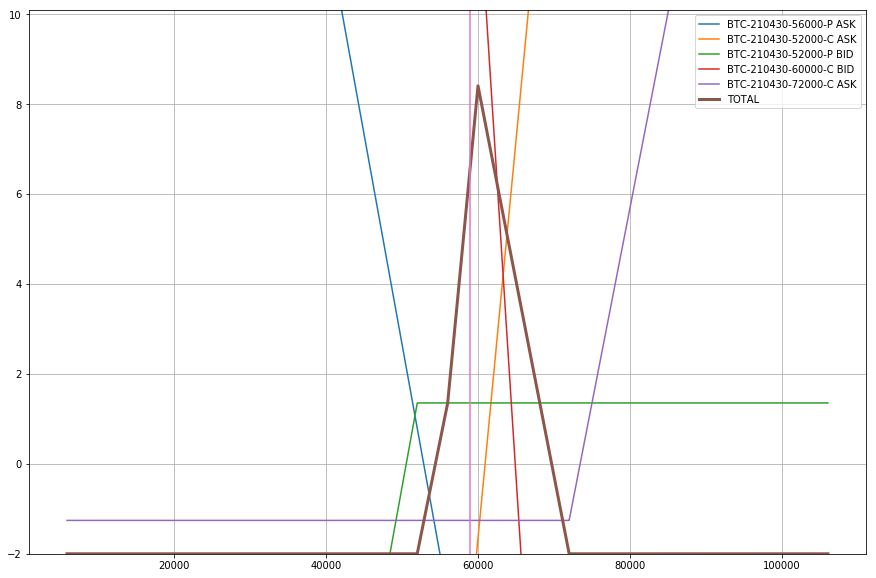

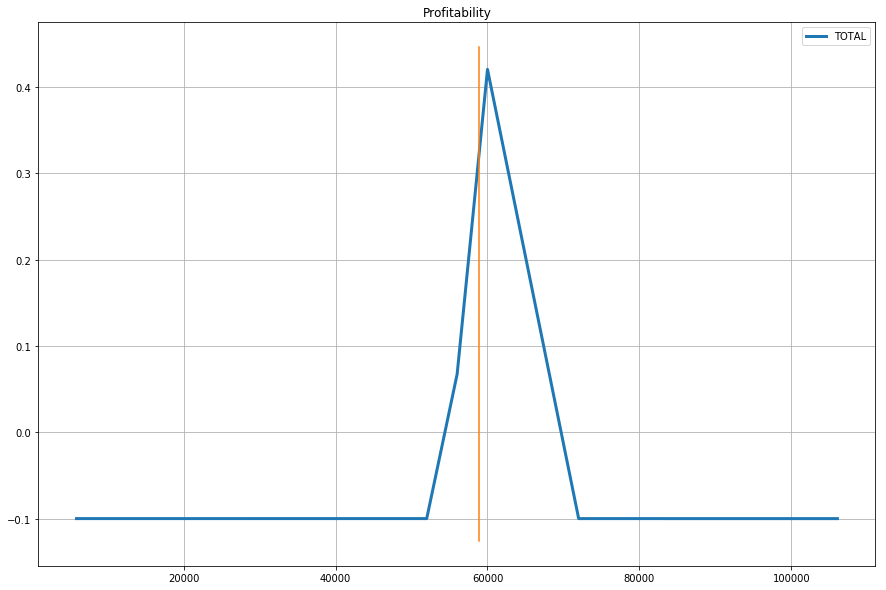

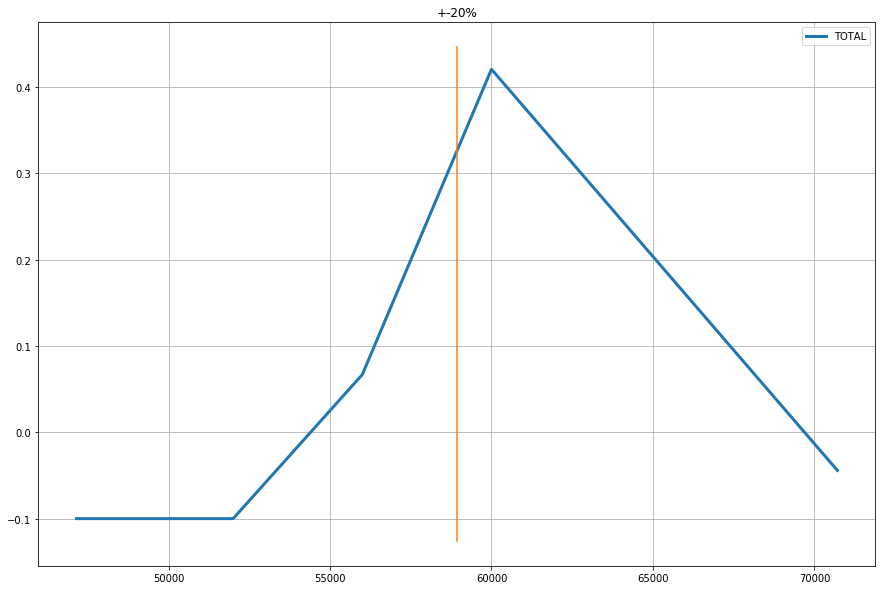

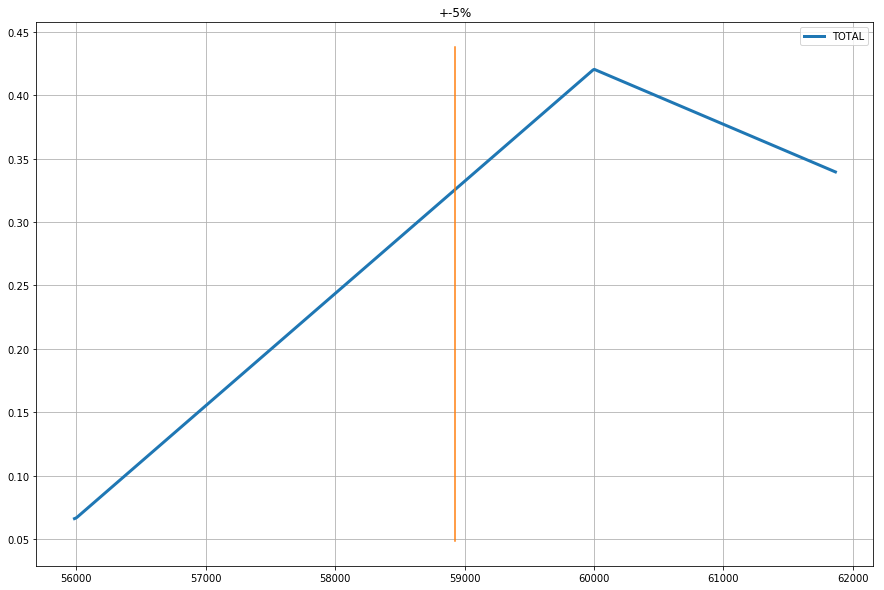

In [228]:
total_pl = 0
total_cost = 0

for i in options:
    v = option_cost_variable[i]
    d = df.iloc[i]
    if v.value() > 0.0:
        ret = v.value() / d.price * pl_order(d, xs)
        cos = v.value() / d.price * cost_order(d, xs)
        plt.plot(xs, ret, label=f"{d.symbol} {d.side}")
        total_pl += ret
        total_cost += cos

plt.plot(xs, total_pl, label="TOTAL", linewidth=3)
plt.grid()
plt.legend()
plot_price(indexPrice)
plt.ylim([max(np.min(total_pl), -1000), np.max(total_pl)*1.2])

plt.show()

plt.title("Profitability")
plt.plot(xs, total_pl / total_cost, label="TOTAL", linewidth=3)
plt.grid()
plt.legend()
plot_price(indexPrice)

plt.show()

plt.title("+-20%")
idx = (xs >= indexPrice*0.80) & (xs <=indexPrice*1.20)
plt.plot(xs[idx], total_pl[idx] / total_cost[idx], label="TOTAL", linewidth=3)
plt.grid()
plt.legend()
plot_price(indexPrice)
plt.show()

plt.title("+-5%")
idx = (xs >= indexPrice*0.95) & (xs <=indexPrice*1.05)
plt.plot(xs[idx], total_pl[idx] / total_cost[idx], label="TOTAL", linewidth=3)
plt.grid()
plt.legend()
plot_price(indexPrice)